In [1]:
# This code is heavily based on Jan Mentzen's implementation of a VAE (https://jmetzen.github.io/2015-11-27/vae.html)

import numpy as np
import tensorflow as tf
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pickle as pkl

np.random.seed(0)
tf.set_random_seed(0)



/Users/dasha/src/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/dasha/src/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/dasha/src/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/dasha/src/anaconda3/lib/python3.6/site-packages/tensorflow/pyth

In [61]:
DIM = 64 # Model dimensionality (number of neurons in the hidden layer(s))
CRITIC_ITERS = 50 # How many critic iterations (Sinkhorn iterations) per generator iteration#was 50
BATCH_SIZE = 256 # Batch size
ITERS = 2500#100000 # how many generator iterations to train for
DATA_DIM = 32
LATENT_DIM = 4
INITIALIZATION = 'he'#'glorot'
COVARIANCE_SCALE = np.sqrt(DATA_DIM)
INITIALIZE_LAST = True
SAMPLE_SIZE = 100000
LAMBDA = 2/(COVARIANCE_SCALE)
MODE = 'divergence' #'loss'

In [3]:
# define some useful functions

def init_params(n_in,n_out):
    '''Create a convolution filter variable with the specified name and shape,
    and initialize it using Xavier initialition.'''
    if INITIALIZATION == 'he':
        initializer = tf.keras.initializers.he_uniform()
    if INITIALIZATION == 'glorot':
        initializer = tf.keras.initializers.glorot_uniform()
    variable = tf.Variable(initializer(shape=[n_in,n_out]))
    return variable

def cost_mat(X,Y,N,M): #for Sinkhorm divergence
    XX = tf.reduce_sum(tf.multiply(X,X),axis=1)#norms of X
    YY = tf.reduce_sum(tf.multiply(Y,Y),axis=1)#norms of Y
    C1 = tf.transpose(tf.reshape(tf.tile(XX,[M]),[M,N]))
    C2 = tf.reshape(tf.tile(YY,[N]),[N,M])
    C3 = tf.transpose(tf.matmul(Y,tf.transpose(X)))
    C = C1 + C2 - 2*C3; #squared norms of difference
    return C

def K_tild(u,v,C,N,M,epsilon):
    C_tild = C - tf.transpose(tf.reshape(tf.tile(u[:,0],[M]),[M,N])) - tf.reshape(tf.tile(v[:,0],[N]),[N,M])
    K_tild = tf.exp(-C_tild/epsilon)
    return K_tild


def log_K_tild(u,v,C,N,M,epsilon):
    C_tild = C - tf.transpose(tf.reshape(tf.tile(u[:,0],[M]),[M,N])) - tf.reshape(tf.tile(v[:,0],[N]),[N,M])
    return -C_tild/epsilon

def sinkhorn_step_log(j,u,v,C, N,M,epsilon,diff,Lambda = 1):
    mu = tf.cast(1/N, tf.float32)
    nu = tf.cast(1/M, tf.float32)
    Ku = tf.reshape( tf.reduce_sum(K_tild(u,v,C,N,M,epsilon),axis = 1) ,[N,1] )
    u_new = Lambda * ( epsilon*(tf.log(mu) - tf.log(Ku +10**(-6))) + u )
    diff = tf.norm(u_new - u)
    u = u_new
    
    Kv = tf.reshape( tf.reduce_sum(K_tild(u,v,C,N,M,epsilon),axis = 0), [M,1] )
    v_new = Lambda * ( epsilon*(tf.log(nu) - tf.log(Kv +10**(-6))) + v )
    diff += tf.norm(v - v_new)
    v = v_new
    j += 1
    return j,u,v,C,N,M,epsilon,diff

def sinkhorn_loss(X,Y):#LOSS, NOT DIVERGENCE
    epsilon = tf.constant(LAMBDA, dtype=tf.float32) # smoothing sinkhorn
    Lambda = tf.constant(1.) # unbalanced parameter
    k = tf.constant(CRITIC_ITERS) # number of iterations for sinkhorn
    N = tf.shape(X)[0] # sample size from mu_theta
    M = tf.shape(Y)[0] # sample size from \hat nu
    
    mu = tf.cast(1/N, tf.float32)
    nu = tf.cast(1/M, tf.float32)
    
    D = tf.shape(Y)[1] # dimension of the obervation space
    C = cost_mat(X,Y,N,M)
    K = tf.exp(-C/epsilon)
    #sinkhorn iterations
    j0 = tf.constant(0)
    u0 = tf.zeros([N,1])
    v0 = tf.zeros([M,1])
    diff = tf.cast(0., tf.float32)
    cond_iter = lambda j, u, v, C, N, M, epsilon, diff: j < k
    j,u,v,C,N,M,epsilon,diff = tf.while_loop(
    cond_iter, sinkhorn_step_log, loop_vars=[j0, u0, v0,C, N,M,epsilon,diff])
    gamma_log = K_tild(u,v,C,N,M,epsilon)
    log_gamma_log = log_K_tild(u,v,C,N,M,epsilon)
    final_cost = tf.reduce_sum(gamma_log*(C+epsilon*(log_gamma_log - tf.log(mu) - tf.log(nu))))
    return final_cost, diff
    

In [4]:
# Variational Autoencoder class


class VariationalAutoencoder(object):
    
    def __init__(self, network_architecture, transfer_fct=tf.nn.relu, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [batch_size, network_architecture["n_input"]])
      
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.Session()
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        self.network_weights = self._initialize_weights(**self.network_architecture)

        # Draw one sample z from uniform in latent space
        n_z = self.network_architecture["n_z"]
        self.z = tf.random_normal((self.batch_size, n_z), dtype=tf.float32)#CHANGE TO GAUSSIAN
        
        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr =   self._generator_network(self.network_weights["weights_gener"],
                                    self.network_weights["biases_gener"])
    
    def _initialize_weights(self, n_hidden_gener_1,  n_hidden_gener_2, n_hidden_gener_3, 
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_gener'] = {
            'h1': init_params(n_z, n_hidden_gener_1),
            'h2': init_params(n_hidden_gener_1, n_hidden_gener_2),
            'h3': init_params(n_hidden_gener_2, n_hidden_gener_3),
            'out_var': init_params(n_hidden_gener_3, n_input)}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'b3': tf.Variable(tf.zeros([n_hidden_gener_3], dtype=tf.float32)),
            'out_var': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights        
   

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), #CHANGE NETWORK ARCHITECTURE TO 3 HID LAYERS
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        layer_3 = self.transfer_fct(tf.add(tf.matmul(layer_2, weights['h3']), 
                                           biases['b3'])) 
        x_reconstr = tf.add(tf.matmul(layer_3, weights['out_var']), 
                                 biases['out_var'])
        return x_reconstr
            
    def _create_loss_optimizer(self):
        # Sinkhorn loss
        cost_xy, self.diff = sinkhorn_loss(self.x, self.x_reconstr)   # average over batch
        cost_xx, self.diff_xx = sinkhorn_loss(self.x_reconstr, self.x_reconstr)   # average over batch
        if MODE == 'divergence':
            self.cost = cost_xy - 0.5 * cost_xx #yy_loss calculated at the end
        else:
            self.cost = cost_xy
        
        fake_data = self.x_reconstr
        mean_fake_data = tf.reduce_mean(fake_data, axis=0, keep_dims=True)
        vx = tf.matmul(tf.transpose(fake_data),fake_data)/tf.cast(tf.shape(fake_data)[0]-1, tf.float32)
        mx = tf.matmul(tf.transpose(mean_fake_data), mean_fake_data)
        fake_data_covariance = vx - mx
        self.fake_data_covariance = fake_data_covariance
        ML_covariance = np.eye(DATA_DIM)/COVARIANCE_SCALE
        self.accuracy = tf.norm(fake_data_covariance - ML_covariance)
        # Use ADAM optimizer
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        if MODE == "divergence":
            _, cost, gen_cov, accuracy, diff, diff_xx, sample = self.sess.run((self.optimizer, self.cost, \
                                        self.fake_data_covariance, self.accuracy, self.diff, self.diff_xx, self.x_reconstr), 
                                  feed_dict={self.x: X})
            return cost, gen_cov, accuracy, diff, diff_xx, sample
        _, cost, gen_cov, accuracy, diff, sample = self.sess.run((self.optimizer, self.cost, \
                                                          self.fake_data_covariance, self.accuracy, self.diff, self.x_reconstr), 
                                  feed_dict={self.x: X})
        return cost, gen_cov, accuracy, diff, sample
    
   
    def generate(self, z_sample):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        
        zz = tf.placeholder(tf.float32, [1, network_architecture["n_z"]])

        
        weights = self.network_weights["weights_gener"]
        biases = self.network_weights["biases_gener"]
        
        layer_1 = self.transfer_fct(tf.add(tf.matmul(zz, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        layer_3 = self.transfer_fct(tf.add(tf.matmul(layer_2, weights['h3']), 
                                           biases['b3'])) 
        x_reconstr = tf.nn.sigmoid(tf.add(tf.matmul(layer_3, weights['out_var']), 
                                 biases['out_var']))
        
        return self.sess.run(x_reconstr,feed_dict={zz: np.reshape(z_sample,[1,network_architecture["n_z"]])})

In [5]:
def inf_train_gen():
    np.random.seed(1)
    full_dataset = np.random.randn(SAMPLE_SIZE,DATA_DIM) / np.sqrt(COVARIANCE_SCALE) 
    i = 0
    offset = 0
    while True:
        dataset = full_dataset[i*BATCH_SIZE+offset:(i+1)*BATCH_SIZE+offset,:]
        if (i+1)*BATCH_SIZE+offset > SAMPLE_SIZE: 
            offset = (i+1)*BATCH_SIZE+offset - SAMPLE_SIZE
            np.random.shuffle(full_dataset)
            dataset = np.concatenate([dataset,full_dataset[:offset,:]], axis = 0)
            i = -1 
        i+=1
        yield dataset
gen = inf_train_gen()

In [ ]:
if MODE == 'divergece':
    model_name = "SINKHORN_"
else:
    model_name = "ENTROPIC_"
model_name = model_name + "_LATENT_DIM_" + str(LATENT_DIM) + "_initialization_" + INITIALIZATION + "_lambda_" + str(int(LAMBDA*1000))
plt.figure()

In [6]:
# Training

def train(network_architecture, learning_rate=0.001,
          batch_size=BATCH_SIZE, total_iter = 2500, display_step = 5):#training_epochs=10, display_step=5):
    print('Compiling...')
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    true_cov = np.eye(DATA_DIM) / COVARIANCE_SCALE
    K = true_cov
    M = np.eye(DATA_DIM) + np.sqrt(np.eye(DATA_DIM) + 16/(LAMBDA**2) * true_cov * true_cov)
    OT_Y = 2 * np.trace(K) - LAMBDA/2 * (np.trace(M) - np.sum(np.log(np.diag(M))) + DATA_DIM * (np.log(2) - 2))
    
    # Training cycle
    print('Training...')
    res = {'cost' : {}, 'gen_cov':{}, 'cov_dist' : {}, 'diff' : {}, 'sample':{}}
    if MODE == 'divergence':
        res['diff_xx'] = {}
#    for epoch in range(training_epochs):
#      print(epoch)
#        avg_cost = 0.
#        total_batch = int(n_samples / batch_size)
        # Loop over all batches
    for i in range(total_iter):#(total_batch):
        batch_xs = next(gen)
        print(i)
        # Fit training using batch data
        latent_var = np.random.normal(size = (batch_size, LATENT_DIM))
        if MODE == 'divergence':
            cost, gen_cov, accuracy, diff, diff_xx, sample = vae.partial_fit(batch_xs)
        else:
            cost, gen_cov, accuracy, diff, sample = vae.partial_fit(batch_xs)
        # Compute average loss
        #avg_cost += cost / n_samples * batch_size
        res['cost'][i] = cost
        if MODE == 'divergence':
            res['cost'][i]-= 0.5*OT_Y
        res['gen_cov'][i] = gen_cov
        res['cov_dist'][i] = accuracy
        res['diff'][i] = diff
        res['sample'][i] = sample
        if MODE == 'divergence':
            res['diff_xx'][i] = diff_xx
        # Display logs per epoch step
        if i%display_step == 0:#epoch % display_step == 0:
            #print("Epoch:", '%04d' % (epoch+1), 
            print("Iteration:", '%04d' % (i+1), 
                  "cost={}, cov_dist={}, difference in Sinkhorn loss={}".format(cost, accuracy, diff))#(avg_cost))
            with open(model_name + '.pkl', 'wb') as f:
                pkl.dump(res, f)
        
    return vae, res

In [7]:
# training the model

network_architecture =     dict(n_hidden_gener_1=DIM, # 1st layer decoder neurons
         n_hidden_gener_2=DIM, # 2nd layer decoder neurons
         n_hidden_gener_3=DIM, # 3rd layer decoder neurons
         n_input=DATA_DIM, # MNIST data input (img shape: 28*28)
         n_z=LATENT_DIM)  # dimensionality of latent space

vae, res = train(network_architecture, total_iter=2000)#, training_epochs=70)

Compiling...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Training...
0
Iteration: 0001 cost=31.023693084716797, cov_dist=11.462632179260254, difference in Sinkhorn loss=5.101893901824951
1
2
3
4
5
Iteration: 0006 cost=22.016267776489258, cov_dist=5.995415210723877, difference in Sinkhorn loss=1.178328275680542
6
7
8
9
10
Iteration: 0011 cost=13.179526329040527, cov_dist=3.7381670475006104, difference in Sinkhorn loss=0.06716279685497284
11
12
13
14
15
Iteration: 0016 cost=9.15720272064209, cov_dist=2.2048821449279785, difference in Sinkhorn loss=0.016835838556289673
16
17
18
19
20
Iteration: 0021 cost=7.488422870635986, cov_dist=1.351628303527832, difference in Sinkhorn loss=0.012848662212491035
21
22
23
24
25
Iteration: 0026 cost=6.559795379638672, cov_dist=1.0090887546539307, difference in Sinkhorn loss=0.007226631976664066
26
27
28
29
30
Iteration: 0031 cost=5.769678115844727, cov_dist=0.7988876700401306, di

277
278
279
280
Iteration: 0281 cost=4.832376956939697, cov_dist=0.8481124639511108, difference in Sinkhorn loss=0.002778727561235428
281
282
283
284
285
Iteration: 0286 cost=4.6731438636779785, cov_dist=0.8340267539024353, difference in Sinkhorn loss=0.0021194054279476404
286
287
288
289
290
Iteration: 0291 cost=4.877416610717773, cov_dist=0.8340209126472473, difference in Sinkhorn loss=0.0028659156523644924
291
292
293
294
295
Iteration: 0296 cost=4.939450263977051, cov_dist=0.8323338031768799, difference in Sinkhorn loss=0.0028115841560065746
296
297
298
299
300
Iteration: 0301 cost=4.795295238494873, cov_dist=0.8433206081390381, difference in Sinkhorn loss=0.003288477659225464
301
302
303
304
305
Iteration: 0306 cost=4.957042694091797, cov_dist=0.8297122716903687, difference in Sinkhorn loss=0.0032235158141702414
306
307
308
309
310
Iteration: 0311 cost=4.919084548950195, cov_dist=0.8479304909706116, difference in Sinkhorn loss=0.0021883449517190456
311
312
313
314
315
Iteration: 0

574
575
Iteration: 0576 cost=4.844698905944824, cov_dist=0.8428666591644287, difference in Sinkhorn loss=0.0028961263597011566
576
577
578
579
580
Iteration: 0581 cost=4.712542533874512, cov_dist=0.8423457741737366, difference in Sinkhorn loss=0.002054741373285651
581
582
583
584
585
Iteration: 0586 cost=4.813575267791748, cov_dist=0.8477518558502197, difference in Sinkhorn loss=0.00044436281314119697
586
587
588
589
590
Iteration: 0591 cost=4.653743267059326, cov_dist=0.8465667366981506, difference in Sinkhorn loss=0.0006865016184747219
591
592
593
594
595
Iteration: 0596 cost=4.850132465362549, cov_dist=0.8399831652641296, difference in Sinkhorn loss=0.0011877268552780151
596
597
598
599
600
Iteration: 0601 cost=4.783637523651123, cov_dist=0.840811550617218, difference in Sinkhorn loss=0.0021043363958597183
601
602
603
604
605
Iteration: 0606 cost=4.831373691558838, cov_dist=0.8368014097213745, difference in Sinkhorn loss=0.002892549615353346
606
607
608
609
610
Iteration: 0611 cost=

872
873
874
875
Iteration: 0876 cost=4.817408561706543, cov_dist=0.8433938026428223, difference in Sinkhorn loss=0.0017051070462912321
876
877
878
879
880
Iteration: 0881 cost=4.887883186340332, cov_dist=0.8370131254196167, difference in Sinkhorn loss=0.00282724155113101
881
882
883
884
885
Iteration: 0886 cost=4.8950276374816895, cov_dist=0.8455342650413513, difference in Sinkhorn loss=0.001238080207258463
886
887
888
889
890
Iteration: 0891 cost=4.867019176483154, cov_dist=0.8378756642341614, difference in Sinkhorn loss=0.0027063193265348673
891
892
893
894
895
Iteration: 0896 cost=4.849330902099609, cov_dist=0.8301366567611694, difference in Sinkhorn loss=0.002420547418296337
896
897
898
899
900
Iteration: 0901 cost=4.828757286071777, cov_dist=0.8410102128982544, difference in Sinkhorn loss=0.0010856989538297057
901
902
903
904
905
Iteration: 0906 cost=4.8126702308654785, cov_dist=0.8437414765357971, difference in Sinkhorn loss=0.002217036671936512
906
907
908
909
910
Iteration: 091

In [63]:

# true_cov = np.eye(DATA_DIM) / COVARIANCE_SCALE
# def OT_normal(true_cov):#true_cov has to be diag
# #true_cov = np.eye(DATA_DIM) / COVARIANCE_SCALE
#     n = true_cov.shape[0]
#     K = true_cov
#     M = np.eye(n) + np.sqrt(np.eye(n) + 16/(LAMBDA**2) * true_cov * true_cov)
#     return 2 * np.trace(K) - LAMBDA/2 * (np.trace(M) - np.sum(np.log(np.diag(M))) + n * (np.log(2) - 2))

# Sink = (OT_normal(true_cov[:LATENT_DIM,:LATENT_DIM]) - OT_normal(true_cov))/2 + (DATA_DIM-LATENT_DIM)/COVARIANCE_SCALE

# true_cov = np.eye(DATA_DIM) / COVARIANCE_SCALE
# K = true_cov
# M = np.eye(DATA_DIM) + np.sqrt(np.eye(DATA_DIM) + 16/(LAMBDA**2) * true_cov * true_cov)
# OT_Y = 2 * np.trace(K) - LAMBDA/2 * (np.trace(M) - np.sum(np.log(np.diag(M))) + DATA_DIM * (np.log(2) - 2))

In [70]:
2/COVARIANCE_SCALE

0.35355339059327373

In [71]:
SINKH_LAMB = [0.01, 0.1, 0.3, 1.]
ENTR_LAMB = [0.01, 0.1, 0.3]

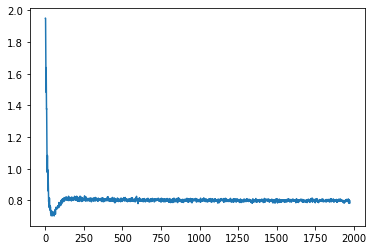

In [101]:
with open('SINKHORN__LATENT_DIM_32_initialization_he_lambda_300.pkl', 'rb') as f:
    res = pkl.load(f)

cov_diff = []
x,y = zip(*res['gen_cov'].items())

DATA_DIM = 32
true_cov = np.eye(DATA_DIM) / COVARIANCE_SCALE

plt.plot(list(map(lambda a: np.linalg.norm(a - true_cov), list(y)))[20:])

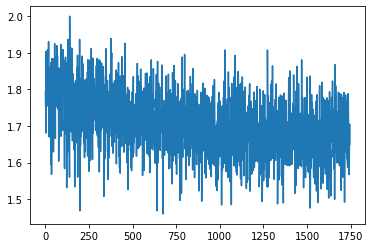

In [104]:
x,y = zip(*res['cost'].items())

true_cov = np.eye(DATA_DIM) / COVARIANCE_SCALE

plt.plot(y[250:])

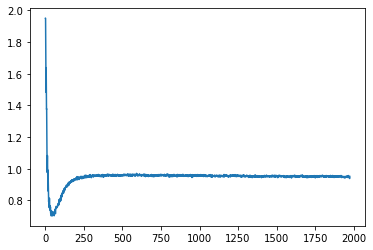

In [96]:
with open('ENTROPIC__LATENT_DIM_32_initialization_he_lambda_300.pkl', 'rb') as f:
    res = pkl.load(f)

cov_diff = []
x,y = zip(*res['gen_cov'].items())

DATA_DIM = 32
true_cov = np.eye(DATA_DIM) / COVARIANCE_SCALE

plt.plot(list(map(lambda a: np.linalg.norm(a - true_cov), list(y)))[20:])

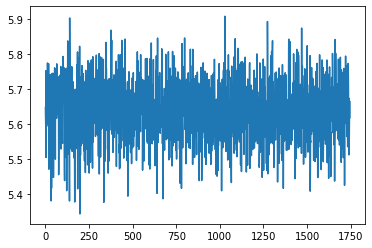

In [100]:

x,y = zip(*res['cost'].items())

true_cov = np.eye(DATA_DIM) / COVARIANCE_SCALE

plt.plot(y[250:])